In [20]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import pandas as pd
import numpy as np
from lime.lime_text import LimeTextExplainer
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [21]:
# Read the HIV classification dataset
df = pd.read_csv("test.csv")
df = df.dropna(subset=["text", "flag"])

In [30]:
label_names = ["Exclusion", "Inclusion"]
model_paths = {
    "mbert": "mbert",
    "mbert-nl-clin": "mbert-nl-clin",
    "mbert-nl-bio": "mbert-nl-bio"
}


In [31]:
def build_predict_fn(model_path):
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model.eval()

    def predict(texts):
        inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=512)
        with torch.no_grad():
            logits = model(**inputs).logits
            probs = torch.softmax(logits, dim=1).numpy()
        return probs

    return predict

In [32]:
for model_name, model_path in model_paths.items():
    print(f"Predicting with {model_name}...")
    predict_fn = build_predict_fn(model_path)
    probs = predict_fn(df["text"].tolist())
    preds = np.argmax(probs, axis=1)
    df[f"{model_name}_pred"] = preds
    df[f"{model_name}_prob"] = probs[:, 1]  # Inclusion


Predicting with mbert...
Predicting with mbert-nl-clin...
Predicting with mbert-nl-bio...


In [ ]:
explainer = LimeTextExplainer(class_names=label_names)

for model_name in model_paths:
    fn_df = df[(df["flag"] == 1) & (df[f"{model_name}_pred"] == 0)]

    print(f"\nFound {len(fn_df)} False Negatives for {model_name}.\n")
    predict_fn = build_predict_fn(model_paths[model_name])

    for i, row in fn_df.head(3).iterrows():
        text = row["text"]

        exp = explainer.explain_instance(text, predict_fn, num_features=10, top_labels=1, num_samples=300)
        fig = exp.as_pyplot_figure(label=0)
        plt.title(f"LIME for FN (Sample {i}) - {model_name}")
        plt.savefig(f"lime_{model_name}_sample_{i}.png", dpi=300)
        plt.close()

In [37]:
one_sample = df.iloc[77]
one_sample

Unnamed: 0.1                                                       6163
Unnamed: 0                                                         6163
Pseudoniem                                                    117229848
text                  Bloed onderzoek: normaal bloedonderzoek hiv: n...
flag                                                                  1
mbert_pred                                                            0
mbert_prob                                                     0.378509
mbert-nl-clin_pred                                                    1
mbert-nl-clin_prob                                             0.775704
mbert-nl-bio_pred                                                     0
mbert-nl-bio_prob                                              0.282781
Name: 77, dtype: object

In [ ]:
predict_fn_1 = build_predict_fn(model_paths["mbert-nl-clin"])

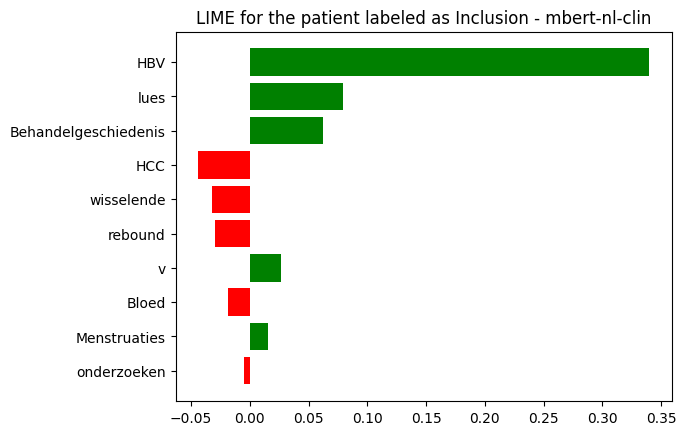

In [45]:
exp = explainer.explain_instance(one_sample["text"], predict_fn_1, num_features=10, top_labels=1, num_samples=300)
fig = exp.as_pyplot_figure(label=1)
plt.title(f"LIME for the patient labeled as Inclusion - mbert-nl-clin")
plt.show()

In [47]:
predict_fn_2 = build_predict_fn(model_paths["mbert"])

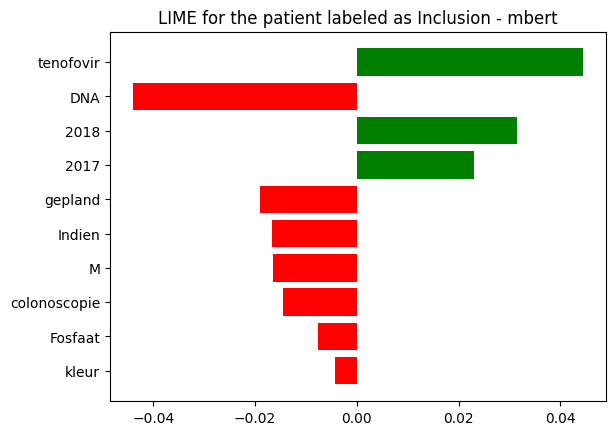

In [55]:
exp = explainer.explain_instance(one_sample["text"], predict_fn_2, num_features=10, top_labels=1, num_samples=300)
fig = exp.as_pyplot_figure(label=0)
plt.title(f"LIME for the patient labeled as Inclusion - mbert")
plt.show()

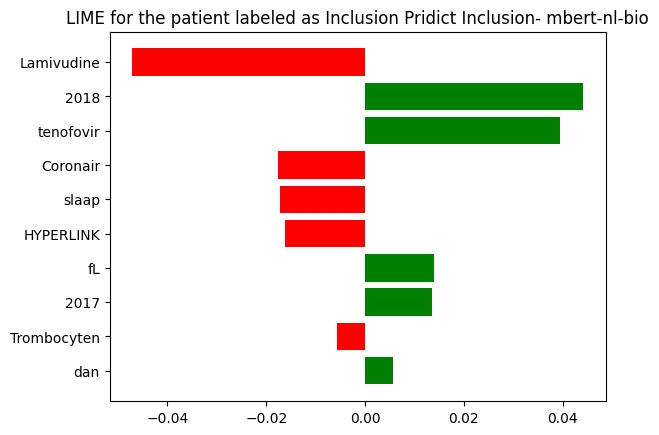

In [56]:
predict_fn_3 = build_predict_fn(model_paths["mbert-nl-bio"])
exp = explainer.explain_instance(one_sample["text"], predict_fn_3, num_features=10, top_labels=1, num_samples=300)
fig = exp.as_pyplot_figure(label=0)
plt.title(f"LIME for the patient labeled as Inclusion Pridict Inclusion- mbert-nl-bio")
plt.show()